In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

## **ÌïôÏäµ & ÌÖåÏä§Ìä∏ ÌîÑÎ°úÏÑ∏Ïä§ ÏöîÏïΩ**
| Îã®Í≥Ñ | ÌïôÏäµ (Train) | ÌÖåÏä§Ìä∏ (Test) |
|------|------------|-------------|
| **1. Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†•** | CSV ÌååÏùº (Ïù¥ÎØ∏ Ï∂îÏ∂úÎêú ÌäπÏßïÍ∞í) | ÎèôÏòÅÏÉÅ |
| **2. ÌäπÏßï Ï∂îÏ∂ú** | CSVÏóêÏÑú Î∂àÎü¨Ïò§Í∏∞ | ÎèôÏòÅÏÉÅ ‚Üí ÌîÑÎ†àÏûÑ Ï∂îÏ∂ú ‚Üí 12Í∞ú Î¨∂Ïùå ‚Üí ÌäπÏßï Ï∂îÏ∂ú |
| **3. Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò** | `(Î∞∞Ïπò, 12, 5)` ÌòïÌÉúÎ°ú Î≥ÄÌôò | `(1, 12, 5)` ÌòïÌÉúÎ°ú Î≥ÄÌôò |
| **4. Î™®Îç∏ ÌïôÏäµ/ÏòàÏ∏°** | LSTM Î™®Îç∏ ÌïôÏäµ | LSTM Î™®Îç∏ÏùÑ Ïù¥Ïö©Ìï¥ ÏòàÏ∏° |
| **5. Í≤∞Í≥º Ï†ÄÏû•** | `.pth` ÌååÏùºÎ°ú Ï†ÄÏû• | ÏòàÏ∏°Í∞í Ï∂úÎ†• |


# 1. ÌïôÏäµ

1. Ï∂îÏ∂úÎêú feature Î°úÎìú Î∞è Î≥ëÌï©
2. LSTM Input ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
3. LSTM ÌïôÏäµ

## ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏

In [2]:
# !pip install koreanize-matplotlib

In [3]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import koreanize_matplotlib
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

## 1-2. LSTM Input ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò

### Config ÏÑ§Ï†ï

In [4]:
config = {
    # RNN ÏÑ§Ï†ï
    "RNN_hidden_layers": 3,  # LSTM Layer Í∞úÏàò
    "RNN_hidden_nodes": 512,  # RNN Hidden State ÌÅ¨Í∏∞
    "RNN_FC_dim": 256,  # RNN ÏµúÏ¢Ö FC Layer Îâ¥Îü∞ Í∞úÏàò
    "dropout_p": 0.2,  # ÎìúÎ°≠ÏïÑÏõÉ ÎπÑÏú®

    # ÌïôÏäµ ÏÑ§Ï†ï
    "k": 4,  # ÌÅ¥ÎûòÏä§ Í∞úÏàò (normal, yawn, phonecall, text)
    "feature_num": 5, # Pitch, Yaw, EAR, MAR, Phone Detected
    "timestep": 24,
    "sliding_step": 6,
    "epochs": 100,  # Ï¥ù ÌïôÏäµ ÌöüÏàò
    "batch_size": 32,  # Î∞∞Ïπò ÌÅ¨Í∏∞
    "learning_rate": 1e-4,  # ÌïôÏäµÎ•†
    "log_interval": 5,  # Î™á Î≤àÏùò Î∞∞ÏπòÎßàÎã§ Î°úÍ∑∏ Ï∂úÎ†•Ìï†ÏßÄ

    "action_names": ["normal", "phonecall", "text", "yawn"],  # Î∂ÑÎ•òÌï† ÌñâÎèô Î¶¨Ïä§Ìä∏

    "use_cuda": torch.cuda.is_available(),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂ÄÏóê Îî∞Îùº ÏÑ§Ï†ï
    "early_stopping_patience": 20,  # Early Stopping Í∏∞Ï§Ä Epoch
    "reduce_lr_factor": 0.1,  # Learning Rate Í∞êÏÜå ÎπÑÏú®
    "reduce_lr_patience": 3,  # Learning Rate Í∞êÏÜå Í∏∞Ï§Ä Epoch

    "random_seed": 24,

    # Î™®Îç∏ Í≤∞Í≥º Ï†ÄÏû• Í≤ΩÎ°ú
    "model_save_path": "/content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr",
    "train_result_path": "/content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results",
}

In [5]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU Ïó∞ÏÇ∞Ïóê ÎåÄÌïú ÏãúÎìú ÏÑ§Ï†ï
    torch.cuda.manual_seed(seed)  # CUDA Ïó∞ÏÇ∞Ïóê ÎåÄÌïú ÏãúÎìú ÏÑ§Ï†ï (GPU ÏÇ¨Ïö© Ïãú)
    torch.cuda.manual_seed_all(seed)  # Ïó¨Îü¨ GPUÎ•º ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÏö∞ Î™®Îì† GPUÏóê ÎèôÏùºÌïú ÏãúÎìú ÏÑ§Ï†ï
    np.random.seed(seed)  # NumPy Ïó∞ÏÇ∞Ïóê ÎåÄÌïú ÏãúÎìú ÏÑ§Ï†ï
    random.seed(seed)  # Python Í∏∞Î≥∏ random Î™®ÎìàÏùò ÏãúÎìú ÏÑ§Ï†ï
    torch.backends.cudnn.deterministic = True  # CuDNN Ïó∞ÏÇ∞Ïùò Í≤∞Ï†ïÎ°†Ï†Å ÎèôÏûë Î≥¥Ïû•
    torch.backends.cudnn.benchmark = False  # ÏÑ±Îä• ÏµúÏ†ÅÌôî ÎπÑÌôúÏÑ±Ìôî (Ïû¨ÌòÑÏÑ± Î≥¥Ïû•)

In [6]:
set_random_seed(config["random_seed"])

## Îç∞Ïù¥ÌÑ∞ Î°úÎìú

### process_features

In [7]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
BATCH_SIZE = config['batch_size']
TIMESTEP = config['timestep']
FEATURE_DIM = config['feature_num'] # Pitch, Yaw, EAR, MAR, Phone Detected
NUM_CLASSES = config['k']  # normal, phonecall, text, yawn
SLIDING_STEP = config['sliding_step']
label_mapping = {"normal": 0, "phonecall": 1, "text": 2, "yawn": 3}
label_mapping_inverse = {0: "normal", 1: "phonecall", 2: "text", 3: "yawn"}

# Í≥µÌÜµ Î°úÏßÅ: Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï≤òÎ¶¨ Î∞è ÏãúÌÄÄÏä§ ÏÉùÏÑ±
def process_features(df, sliding_labels=None, yaw_inversion_labels=None, is_train=True):
    """
    Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú ÏãúÌÄÄÏä§Î•º ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò.

    Args:
        df (pd.DataFrame): ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ.
        sliding_labels (list): Sliding window Î∞©Ïãù Ï†ÅÏö©Ìï† ÎùºÎ≤® Î¶¨Ïä§Ìä∏ (Ïòà: ['text', 'yawn']).
        is_train (bool): ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Ïó¨Î∂Ä. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Îäî sliding stepÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏùå.

    Returns:
        torch.Tensor: ÏãúÌÄÄÏä§ Îç∞Ïù¥ÌÑ∞.
        torch.Tensor: ÎùºÎ≤® Îç∞Ïù¥ÌÑ∞.
        list: Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ (label, group_key, sequence_index).
        np.array: StratifiedGroupkFold ÏûÖÎ†•Ïö© person ids
    """
    # label Ïù∏ÏΩîÎî©
    df['label_encoded'] = df['label'].map(label_mapping)

    sequences = []
    labels = []
    person_ids = [] # cv Ïö©
    metadata = []  # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû• Î¶¨Ïä§Ìä∏

    for (label_encoded, group_key), group in df.groupby(['label_encoded', 'video_clip']):
        group = group.sort_values(by='frame')  # ÌîÑÎ†àÏûÑ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨
        features = group[["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]].values
        person_id = group_key.split("_")[0]

        # Sliding window Î∞©Ïãù Ï†ÅÏö© Ïó¨Î∂Ä Í≤∞Ï†ï
        if is_train and sliding_labels and label_mapping_inverse[label_encoded] in sliding_labels:
            step_size = SLIDING_STEP
        else:
            step_size = TIMESTEP

        # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º Ï≤òÎ¶¨
        for start_idx in range(0, len(features) - TIMESTEP + 1, step_size):
            end_idx = start_idx + TIMESTEP
            if end_idx <= len(features):
                sequences.append(features[start_idx:end_idx])
                labels.append(label_encoded)
                person_ids.append(person_id)
                metadata.append((label_encoded, group_key, start_idx))  # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä

        # yaw_inversion_labels Ìï¥Îãπ
        if is_train and yaw_inversion_labels and label_mapping_inverse[label_encoded] in yaw_inversion_labels:
            inverted_features = features.copy()
            inverted_features[:, 1] = -inverted_features[:, 1]  # gaze_yaw Î∞òÏ†Ñ (Ï≤´ Î≤àÏß∏ Ïª¨Îüº)

            for start_idx in range(0, len(inverted_features) - TIMESTEP + 1, step_size):
                end_idx = start_idx + TIMESTEP
                if end_idx <= len(inverted_features):  # ÎßàÏßÄÎßâ ÏãúÌÄÄÏä§Í∞Ä seq_lengthÏóê ÎßûÎäî Í≤ΩÏö∞Îßå Ï≤òÎ¶¨
                    sequences.append(inverted_features[start_idx:end_idx])
                    labels.append(label_encoded)
                    person_ids.append(person_id)
                    metadata.append((label_encoded, group_key, start_idx))  # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä

    # pytorch tensor Î≥ÄÌôò
    return (torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long), metadata, np.array(person_ids))


# ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
def load_train_features(df):
    """
    ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞Î•º Ï≤òÎ¶¨ÌïòÏó¨ ÏãúÌÄÄÏä§Î•º ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò.
    """
    sliding_labels = ['yawn', 'text']  # Sliding window Î∞©Ïãù Ï†ÅÏö©Ìï† ÎùºÎ≤® Î¶¨Ïä§Ìä∏
    yaw_inversion_labels = ['yawn', 'text']
    return process_features(df, sliding_labels=sliding_labels, yaw_inversion_labels=yaw_inversion_labels, is_train=True)

# ÌÖåÏä§Ìä∏Ïö© Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
def load_test_features(df):
    """
    ÌÖåÏä§Ìä∏Ïö© Îç∞Ïù¥ÌÑ∞Î•º Ï≤òÎ¶¨ÌïòÏó¨ ÏãúÌÄÄÏä§Î•º ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò.
    """
    return process_features(df, sliding_labels=None, is_train=False)

### train, test data load

In [8]:
train = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/train_processed.csv")
test = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/test_processed.csv")

## train, validation Î∂ÑÎ¶¨

In [9]:
from sklearn.model_selection import train_test_split

# Step 1: ÏÇ¨ÎûåÎ≥Ñ ID Ï∂îÏ∂ú
def get_person_id(video_name):
    """
    video_nameÏóêÏÑú ÏÇ¨ÎûåÎ≥Ñ IDÎ•º Ï∂îÏ∂úÌï©ÎãàÎã§.
    """
    return video_name.split("_")[0]  # Ïòà: "dash#", "mirror#", "gA#" Îì±

# Îç∞Ïù¥ÌÑ∞Ïóê person_id Ïó¥ Ï∂îÍ∞Ä
train['person_id'] = train['video_name'].apply(get_person_id)

# Step 2: ÏÇ¨ÎûåÎ≥ÑÎ°ú trainÍ≥º validation ÏÑ∏Ìä∏ ÎÇòÎàÑÍ∏∞
def split_by_person(data, test_size=0.2, random_state=42):
    """
    ÏÇ¨ÎûåÎ≥ÑÎ°ú Îç∞Ïù¥ÌÑ∞Î•º trainÍ≥º validation ÏÑ∏Ìä∏Î°ú ÎÇòÎàïÎãàÎã§.

    Args:
        data (pd.DataFrame): Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ.
        test_size (float): validation ÏÑ∏Ìä∏ ÎπÑÏú®.
        random_state (int): ÎûúÎç§ ÏãúÎìú Í∞í.

    Returns:
        train_data (pd.DataFrame): Train Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ.
        validation_data (pd.DataFrame): Validation Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ.
    """
    # Í≥†Ïú†Ìïú person_id Î™©Î°ù Ï∂îÏ∂ú
    unique_person_ids = data['person_id'].unique()

    # person_idÎ•º Í∏∞Ï§ÄÏúºÎ°ú train/validation Î∂ÑÎ¶¨
    train_ids, validation_ids = train_test_split(unique_person_ids, test_size=test_size, random_state=random_state)

    # train/validation Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
    train_data = data[data['person_id'].isin(train_ids)]
    validation_data = data[data['person_id'].isin(validation_ids)]

    return train_data, validation_data

# Train/Validation Î∂ÑÎ¶¨
train_data_origin, validation_data_origin = split_by_person(train)

# Step 3: ÎùºÎ≤®Î≥Ñ ÎπÑÏú® ÌôïÏù∏ Ìï®Ïàò
def check_label_distribution(data, label_column='label'):
    """
    Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÎùºÎ≤®Î≥Ñ ÎπÑÏú®ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.

    Args:
        data (pd.DataFrame): ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ.
        label_column (str): ÎùºÎ≤® Ïª¨Îüº Ïù¥Î¶Ñ.

    Returns:
        pd.Series: ÎùºÎ≤®Î≥Ñ ÎπÑÏú®.
    """
    label_counts = data[label_column].value_counts(normalize=True) * 100  # ÎπÑÏú® Í≥ÑÏÇ∞ (%)
    return label_counts

# Train/ValidationÏùò ÎùºÎ≤®Î≥Ñ ÎπÑÏú® ÌôïÏù∏
train_label_distribution = check_label_distribution(train_data_origin)
validation_label_distribution = check_label_distribution(validation_data_origin)

# Í≤∞Í≥º Ï∂úÎ†•
print("Train Label Distribution (%):")
print(train_label_distribution)

print("\nValidation Label Distribution (%):")
print(validation_label_distribution)

# Train/Validation Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞ ÌôïÏù∏
print(f"\nTrain Data: {len(train_data_origin)} rows")
print(f"Validation Data: {len(validation_data_origin)} rows")

Train Label Distribution (%):
label
normal       62.678311
phonecall    24.133916
text          8.922853
yawn          4.264920
Name: proportion, dtype: float64

Validation Label Distribution (%):
label
normal       60.106667
phonecall    24.000000
text         11.946667
yawn          3.946667
Name: proportion, dtype: float64

Train Data: 82440 rows
Validation Data: 22500 rows


In [10]:
sort_key = ["label", "video_name", "frame", "video_clip"]
features = ["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]
train = train_data_origin[sort_key + features]
validation = validation_data_origin[sort_key + features]
test = test[sort_key + features]

### train normal 1, 2Îßå ÏÑ†ÌÉù

In [11]:
print(f"before filtering normal: {len(train)}")
train = train[
    ((train['label'] == 'normal') &
     ((train['video_name'].str.split('_').str[-1] == 'part1') |
      (train['video_name'].str.split('_').str[-1] == 'part2'))) |
    (train['label'] != 'normal')
]
display(train.head())
print(f"after filtering normal: {len(train)}")

before filtering normal: 82440


label                                         video_name            frame  \
0  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000000.jpg   
1  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000001.jpg   
2  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000002.jpg   
3  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000003.jpg   
4  normal  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...  frame000004.jpg   

                                          video_clip  gaze_pitch  gaze_yaw  \
0  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...   -0.802380 -0.178544   
1  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...   -0.258022 -0.444779   
2  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...    0.173530 -0.746606   
3  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...   -0.022168 -0.725515   
4  gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...   -0.187156 -0.672688   

        EAR       MAR  phone_detected  
0  0.188577  0.152621               0  
1  0.115461  0.098821               0  
2  0.101308  0.080448               0  
3  0.101270  0.099019               0  
4  0.110530  0.118148               0

after filtering normal: 55428


In [12]:
train.dropna(inplace=True)
validation.dropna(inplace=True)
test.dropna(inplace=True)
print("ÌïôÏäµ Îç∞Ïù¥ÌÑ∞: ", train.shape)
print("Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: ", validation.shape)
print("ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: ", test.shape)

ÌïôÏäµ Îç∞Ïù¥ÌÑ∞:  (55380, 9)
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞:  (22464, 9)
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞:  (23544, 9)


In [13]:
train_count = train.groupby('label')['label'].count().reset_index(name='frame_count')
train_count['clip_count'] = train_count['frame_count'] // config['timestep']
train_count['ratio'] = round(train_count['clip_count'] / train_count['clip_count'].sum() * 100, 1) # ÎπÑÏú® Í≥ÑÏÇ∞
print("-----------Train-----------")
display(train_count)
print("-----------Validation-----------")
val_count = validation.groupby('label')['label'].count().reset_index(name='frame_count')
val_count['clip_count'] = val_count['frame_count'] // config['timestep']
val_count['ratio'] = round(val_count['clip_count'] / val_count['clip_count'].sum() * 100, 1) # ÎπÑÏú® Í≥ÑÏÇ∞
display(val_count)
print("-----------Test-----------")
test_count = test.groupby('label')['label'].count().reset_index(name='frame_count')
test_count['clip_count'] = test_count['frame_count'] // config['timestep']
test_count['ratio'] = round(test_count['clip_count'] / test_count['clip_count'].sum() * 100, 1) # ÎπÑÏú® Í≥ÑÏÇ∞
display(test_count)

-----------Train-----------


label  frame_count  clip_count  ratio
0     normal        24612        1025   44.4
1  phonecall        19896         829   35.9
2       text         7356         306   13.3
3       yawn         3516         146    6.3

-----------Validation-----------


label  frame_count  clip_count  ratio
0     normal        13512         563   60.1
1  phonecall         5376         224   23.9
2       text         2688         112   12.0
3       yawn          888          37    4.0

-----------Test-----------


label  frame_count  clip_count  ratio
0     normal        14100         587   59.9
1  phonecall         5664         236   24.1
2       text         2568         107   10.9
3       yawn         1212          50    5.1

In [14]:
# Train, Test dataset
train_features, train_labels, train_meta, train_personids = load_train_features(train)
validation_features, validation_labels, validation_meta, validation_personids = load_test_features(validation)
test_features, test_labels, test_meta, test_personids = load_test_features(test)

In [15]:
# Î†àÏù¥Î∏î Í∞úÏàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
label_counts = pd.Series(train_labels).value_counts()
label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100  # ÎπÑÏú® Í≥ÑÏÇ∞ (Î∞±Î∂ÑÏú®)

# Îß§ÌïëÎêú Í≤∞Í≥º Ï∂úÎ†•
print("Î†àÏù¥Î∏î Î∂ÑÌè¨:")
print("-----------Train-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}Í∞ú ({label_ratios[label]:.2f}%)")

# Î†àÏù¥Î∏î Í∞úÏàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
label_counts = pd.Series(validation_labels).value_counts()
label_ratios = pd.Series(validation_labels).value_counts(normalize=True) * 100  # ÎπÑÏú® Í≥ÑÏÇ∞ (Î∞±Î∂ÑÏú®)

print("-----------Validation-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}Í∞ú ({label_ratios[label]:.2f}%)")


# Î†àÏù¥Î∏î Í∞úÏàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
label_counts = pd.Series(test_labels).value_counts()
label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100  # ÎπÑÏú® Í≥ÑÏÇ∞ (Î∞±Î∂ÑÏú®)

print("-----------Test-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}Í∞ú ({label_ratios[label]:.2f}%)")

Î†àÏù¥Î∏î Î∂ÑÌè¨:
-----------Train-----------
text: 1880Í∞ú (46.64%)
normal: 882Í∞ú (21.88%)
phonecall: 797Í∞ú (19.77%)
yawn: 472Í∞ú (11.71%)
-----------Validation-----------
normal: 461Í∞ú (56.70%)
phonecall: 218Í∞ú (26.81%)
text: 106Í∞ú (13.04%)
yawn: 28Í∞ú (3.44%)
-----------Test-----------
normal: 493Í∞ú (57.59%)
phonecall: 229Í∞ú (26.75%)
text: 96Í∞ú (11.21%)
yawn: 38Í∞ú (4.44%)


### Îç∞Ïù¥ÌÑ∞ ÎëòÎü¨Î≥¥Í∏∞ - ÏãúÍ∞ÅÌôî
- ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Í∞úÏàò
- ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò
- ÌÉÄÍ≤üÍ∞í Î∂ÑÌè¨

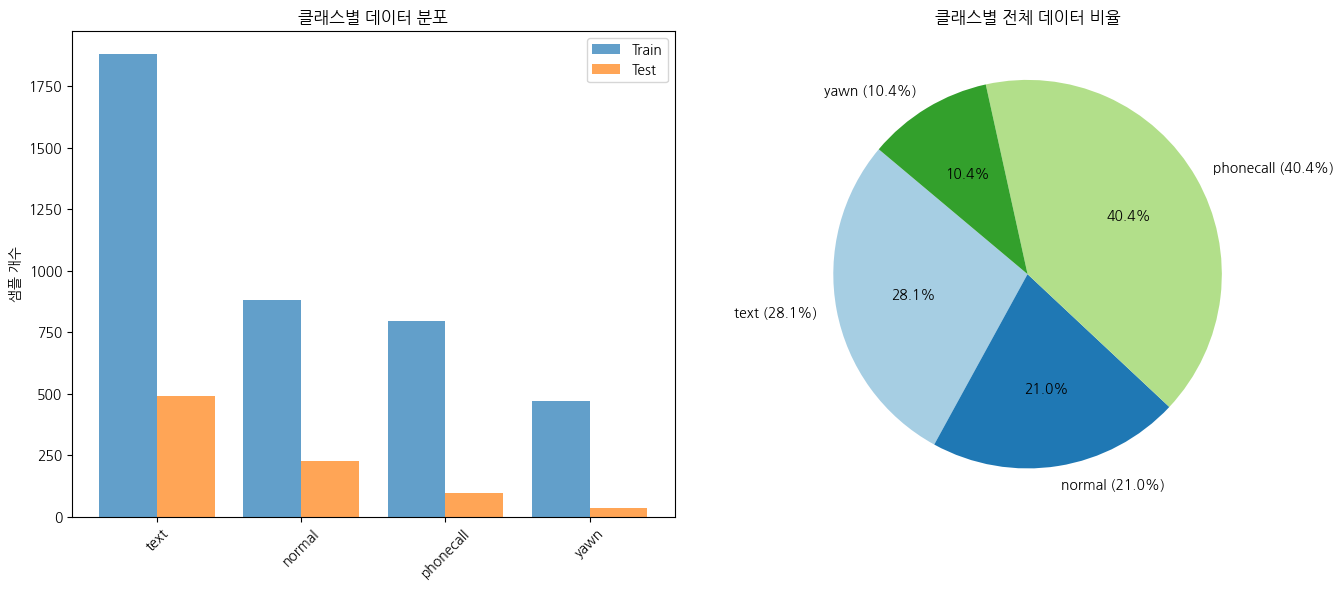

In [16]:
def visualize_data_distribution(train_labels, test_labels, label_mapping_inverse):
    """
    ÌõàÎ†®/ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò.

    Args:
        train_labels (list or pd.Series): ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î.
        test_labels (list or pd.Series): ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î.
        label_mapping_inverse (dict): Ï†ïÏàòÌòï Î†àÏù¥Î∏îÏùÑ Î¨∏ÏûêÏó¥Î°ú Îß§ÌïëÌïòÎäî ÎîïÏÖîÎÑàÎ¶¨.
    """
    # Î†àÏù¥Î∏î Í∞úÏàò Î∞è ÎπÑÏú® Í≥ÑÏÇ∞
    train_label_counts = pd.Series(train_labels).value_counts()
    train_label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100

    test_label_counts = pd.Series(test_labels).value_counts()
    test_label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100

    # ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ Îß§Ìïë
    class_names = [label_mapping_inverse[label] for label in train_label_counts.index]

    # ÏãúÍ∞ÅÌôî
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # (ÏôºÏ™Ω) Bar Chart - ÌÅ¥ÎûòÏä§Î≥Ñ ÏÉòÌîå Í∞úÏàò ÎπÑÍµê
    x = np.arange(len(class_names))
    width = 0.4

    axes[0].bar(x - width / 2, train_label_counts.values, width, label="Train", alpha=0.7)
    axes[0].bar(x + width / 2, test_label_counts.values, width, label="Test", alpha=0.7)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_ylabel("ÏÉòÌîå Í∞úÏàò")
    axes[0].set_title("ÌÅ¥ÎûòÏä§Î≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨")
    axes[0].legend()

    # (Ïò§Î•∏Ï™Ω) Pie Chart - Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®
    total_counts = train_label_counts + test_label_counts
    total_ratios = total_counts / total_counts.sum() * 100

    axes[1].pie(
        total_counts,
        labels=[f"{class_names[i]} ({total_ratios[i]:.1f}%)" for i in range(len(class_names))],
        autopct="%1.1f%%",
        startangle=140,
        colors=plt.cm.Paired.colors,
    )
    axes[1].set_title("ÌÅ¥ÎûòÏä§Î≥Ñ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®")

    plt.tight_layout()
    plt.show()

visualize_data_distribution(train_labels, test_labels, label_mapping_inverse)

### DataLoader

In [17]:
# DataLoader ÏÑ§Ï†ï
params = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": True,
    "persistent_workers": True,
    "prefetch_factor": 2,
} if config["use_cuda"] else {}

In [18]:
# DataLoader ÏÉùÏÑ± (Î∞∞Ïπò Îã®ÏúÑÎ°ú Îç∞Ïù¥ÌÑ∞Î•º ÎÇòÎàÑÍ∏∞ ÏúÑÌï¥ ÏÇ¨Ïö©)
train_dataset = TensorDataset(train_features, train_labels)
validation_dataset = TensorDataset(validation_features, validation_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, **params)
validation_loader = DataLoader(validation_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

# Î∞∞Ïπò Îã®ÏúÑ ÌôïÏù∏
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # Ìïú Î∞∞ÏπòÎßå ÌôïÏù∏

for x_batch, y_batch in validation_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # Ìïú Î∞∞ÏπòÎßå ÌôïÏù∏

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # Ìïú Î∞∞ÏπòÎßå ÌôïÏù∏

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


In [19]:
# # Train, Test ÎùºÎ≤®Î≥Ñ Í∞úÏàò ÌôïÏù∏
labels = train_labels.to(torch.long)#  Long ÌÉÄÏûÖÏúºÎ°ú Î≥ÄÌôò
counts = torch.bincount(labels)
print(counts)

labels = validation_labels.to(torch.long)#  Long ÌÉÄÏûÖÏúºÎ°ú Î≥ÄÌôò
counts = torch.bincount(labels)
print(counts)

labels = test_labels.to(torch.long)
counts = torch.bincount(labels)
print(counts)

tensor([ 882,  797, 1880,  472])
tensor([461, 218, 106,  28])
tensor([493, 229,  96,  38])


## 1-3. LSTM ÌïôÏäµ

In [20]:
# LSTM Î™®Îç∏ Ï†ïÏùò
class DecoderRNN(nn.Module):
    def __init__(self, config):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = config['feature_num']  # ÌäπÏßï Í∞úÏàò
        self.h_RNN_layers = config["RNN_hidden_layers"]
        self.h_RNN = config["RNN_hidden_nodes"]
        self.h_FC_dim = config["RNN_FC_dim"]
        self.drop_p = config["dropout_p"]
        self.num_classes = config["k"]

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        RNN_out, _ = self.LSTM(x_RNN, None)

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])  # ÎßàÏßÄÎßâ ÌÉÄÏûÑÏä§ÌÖùa ÏÇ¨Ïö©
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x  # CrossEntropyLoss ÏÇ¨Ïö© (Softmax ÏóÜÏùå)

### optimizer

In [21]:
def get_optimizer(model, config):
    return optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

### ÌïôÏäµÎ•† Í∞êÏÜå Ïä§ÏºÄÏ§ÑÎü¨ ÏÑ§Ï†ï
Test Loss Í∏∞Ï§Ä
- factor: 0.5, ÌïôÏäµÎ•† 50% Í∞êÏÜå
- verbose: True, Í∞êÏÜåÎêú Í≤ΩÏö∞ Î°úÍ∑∏ Ï∂úÎ†•

In [22]:
def get_scheduler(optimizer, config):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=config["reduce_lr_factor"],
        patience=config["reduce_lr_patience"],
    )

### Early Stopping ÏÑ§Ï†ï

In [23]:
early_stopping_patience = config["early_stopping_patience"]
best_loss = np.inf
patience_counter = 0

## ÌïôÏäµ ÏßÑÌñâ

- Mixed Precision Training Ïú†ÏßÄ (torch.cuda.amp.autocast() + GradScaler())
-  Gradient Clipping Ï∂îÍ∞Ä (torch.nn.utils.clip_grad_norm_()) ‚Üí Ìè≠Î∞úÏ†ÅÏù∏ Í∏∞Ïö∏Í∏∞(Gradient Explosion) Î∞©ÏßÄ
- Î™®Îç∏ Ï†ÄÏû• Í∏∞Îä• Ï∂îÍ∞Ä (torch.save()) ‚Üí Best Loss Í∞±Ïã† Ïãú ÏûêÎèô Ï†ÄÏû•
- ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨ Î°úÍπÖ Ï∂îÍ∞Ä ‚Üí ReduceLROnPlateauÍ∞Ä ÏûëÎèôÌñàÎäîÏßÄ ÌôïÏù∏ Í∞ÄÎä•

In [24]:
def save_best_model(model, optimizer, epoch, best_loss, save_path):
    """Validation LossÍ∞Ä Í∞ÄÏû• ÎÇÆÏùÑ ÎïåÎßå Î™®Îç∏ÏùÑ Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò"""
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")  # ÎÇ†Ïßú Í∞ÄÏ†∏Ïò§Í∏∞
    model_filename = f"{save_path}/best_model_{today_date}.pth"  # Ï†ÄÏû• ÌååÏùºÎ™Ö

    # Í∏∞Ï°¥ ÏµúÏ†Å Î™®Îç∏ ÏÇ≠Ï†ú (Ïù¥Ï†Ñ Î™®Îç∏ Ïú†ÏßÄ Ïïà Ìï®)
    if os.path.exists(model_filename):
        os.remove(model_filename)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }, model_filename)

    print(f"üíæ Best Model Updated! Saved at {model_filename} (Loss: {best_loss:.4f})")

def save_training_results(
        epoch_train_losses,
        epoch_train_scores,
        epoch_test_losses,
        epoch_test_scores,
        save_path="./",
        ):
    """
    ÌïôÏäµ Í≥ºÏ†ïÏùò ÏÜêÏã§(loss)Í≥º Ï†ïÌôïÎèÑ(score)Î•º Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò
    """
    os.makedirs(save_path, exist_ok=True)

    np.save(
        os.path.join(save_path, "LSTM_epoch_training_losses.npy"),
        np.array(epoch_train_losses),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_tsave_path, raining_scores.npy"),
        np.array(epoch_train_scores),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_loss.npy"), np.array(epoch_test_losses)
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_score.npy"),
        np.array(epoch_test_scores),
    )

### epochÎßàÎã§ validation dataÎ°ú ÏÑ±Îä•ÌèâÍ∞Ä
- Îã§Ïùå Í∏∞Ïà†ÏùÑ Ï†ÅÏö©ÌïòÎäî Í∏∞Ï§Ä: Validation data Loss
    - Early Stopping
    - ÌïôÏäµÎ•† Í∞êÏÜå Ïä§ÏºÄÏ§ÑÎü¨
    - Î™®Îç∏ Ï†ÄÏû• (Best Loss Í∞±Ïã† Ïãú)

In [25]:
def ensure_directory_exists(path):
    """Ï£ºÏñ¥ÏßÑ Í≤ΩÎ°úÏùò Ìè¥ÎçîÍ∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"üìÇ Directory created: {path}")

In [26]:
# ‚úÖ Í≤ΩÎ°ú ÏûêÎèô ÏÉùÏÑ± (Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏúºÎ©¥ ÏÉùÏÑ±)
ensure_directory_exists(os.path.dirname(config["model_save_path"]))  # Î™®Îç∏ Ï†ÄÏû• Ìè¥Îçî
ensure_directory_exists(config["train_result_path"])  # ÌïôÏäµ Í≤∞Í≥º Ìè¥Îçî

üìÇ Directory created: /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results


### train & validate

In [27]:
# Mixed Precision TrainingÏùÑ ÏúÑÌïú GradScaler ÏÑ§Ï†ï
scaler = torch.amp.GradScaler()

# ÌïôÏäµ Í≤∞Í≥º Ï†ÄÏû• Ìï®Ïàò
def save_training_results(epoch, train_losses, train_scores, test_losses, test_scores, save_path):
    """ÌïôÏäµ Í≤∞Í≥ºÎ•º CSV ÌååÏùºÎ°ú Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò"""
    results_df = pd.DataFrame({
        "epoch": list(range(1, epoch + 2)),
        "train_loss": train_losses,
        "train_accuracy": train_scores,
        "test_loss": test_losses,
        "test_accuracy": test_scores,
    })

    results_df.to_csv(f"{save_path}/training_results.csv", index=False)
    print(f"üíæ Training results saved at {save_path}/training_results.csv")

# ÌïôÏäµ Ìï®Ïàò
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    losses, scores = [], []
    total_samples = 0

    # tqdmÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌïôÏäµ ÏßÑÌñâÎ•† ÌëúÏãú
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=True)

    for batch_idx, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device).long()
        total_samples += X.size(0)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda'):
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #  Gradient Clipping
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

        # Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
        y_pred = torch.argmax(output, dim=1)
        acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
        scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"‚úÖ Train Epoch {epoch+1} Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

    return avg_loss, avg_acc  # ÌïôÏäµ Loss Î∞è Accuracy Î∞òÌôò

# Í≤ÄÏ¶ù Ìï®Ïàò
def validate(model, device, criterion, test_loader):
    model.eval()
    losses, scores = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).long()

            with torch.amp.autocast(device_type='cuda'):
                output = model(X)
                loss = criterion(output, y)

            losses.append(loss.item())

            # Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
            y_pred = torch.argmax(output, dim=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
            scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"‚úÖ Validation Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

    return avg_loss, avg_acc  # Í≤ÄÏ¶ù Loss Î∞è Accuracy Î∞òÌôò

In [28]:
# Ï†ÑÏ≤¥ ÌïôÏäµ Ïã§Ìñâ ÏΩîÎìú
def train_and_validate(model, train_loader, valid_loader, optimizer, criterion, scheduler, config):
    best_loss = np.inf  # Best Loss Ï¥àÍ∏∞Ìôî
    patience_counter = 0  # Early Stopping Ïπ¥Ïö¥ÌÑ∞

    epoch_train_losses, epoch_train_scores = [], []
    epoch_valid_losses, epoch_valid_scores = [], []

    for epoch in range(config["epochs"]):
        # ÌïôÏäµ Îã®Í≥Ñ
        epoch_train_loss, epoch_train_score = train(
            config["log_interval"], model, config["device"], train_loader, optimizer, criterion, epoch
        )

        # Í≤ÄÏ¶ù Îã®Í≥Ñ
        epoch_valid_loss, epoch_valid_score = validate(
            model, config["device"], criterion, valid_loader,
        )

        # Í≤∞Í≥º Ï†ÄÏû•
        epoch_train_losses.append(epoch_train_loss)
        epoch_train_scores.append(epoch_train_score)
        epoch_valid_losses.append(epoch_valid_loss)
        epoch_valid_scores.append(epoch_valid_score)

        # ÌïôÏäµÎ•† Í∞êÏÜå Ï†ÅÏö©
        scheduler.step(epoch_valid_loss)

        # Early Stopping Ï≤¥ÌÅ¨
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            patience_counter = 0  # Í∞úÏÑ†ÎêòÏóàÏúºÎØÄÎ°ú patience Ï¥àÍ∏∞Ìôî

            save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"])
            print(f"üíæ Model Saved! New Best Loss: {best_loss:.4f}")
        else:
            patience_counter += 1
            print(f"‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: {patience_counter}/{config['early_stopping_patience']}")

        # ÏÑ§Ï†ïÎêú patience ÌöüÏàòÎßåÌÅº Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµ Ï§ëÎã®
        if patience_counter >= config["early_stopping_patience"]:
            print("‚èπÔ∏è Early stopping Ï†ÅÏö©Îê®. ÌïôÏäµ Ï¢ÖÎ£å.")
            break  # ÌïôÏäµ Ï§ëÎã®

        # ÌïôÏäµ Í≤∞Í≥º Ï†ÄÏû•
        save_training_results(
            epoch,
            epoch_train_losses,
            epoch_train_scores,
            epoch_valid_losses,
            epoch_valid_scores,
            save_path=config["train_result_path"],
        )

    return epoch_train_losses, epoch_train_scores, epoch_valid_losses, epoch_valid_scores

In [29]:
model = DecoderRNN(config)
model.to(config["device"])  # Î™®Îç∏ÏùÑ GPUÎ°ú Ïù¥Îèô

optimizer = get_optimizer(model, config)
scheduler = get_scheduler(optimizer, config)

epoch_train_losses, epoch_train_scores, epoch_valid_losses, epoch_valid_scores = train_and_validate(model, train_loader, validation_loader, optimizer, criterion, scheduler, config)
# RuntimeError: DataLoader worker -> dataloader Ïû¨Ïã§Ìñâ

Epoch 1/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:03<00:00, 32.17it/s]


‚úÖ Train Epoch 1 Finished - Avg Loss: 1.3273, Avg Acc: 41.21%
‚úÖ Validation Finished - Avg Loss: 1.5174, Avg Acc: 12.92%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.5174)
üíæ Model Saved! New Best Loss: 1.5174
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 2/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 64.24it/s]


‚úÖ Train Epoch 2 Finished - Avg Loss: 1.2550, Avg Acc: 46.63%
‚úÖ Validation Finished - Avg Loss: 1.4801, Avg Acc: 12.92%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.4801)
üíæ Model Saved! New Best Loss: 1.4801
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 3/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.86it/s]


‚úÖ Train Epoch 3 Finished - Avg Loss: 1.1400, Avg Acc: 50.01%
‚úÖ Validation Finished - Avg Loss: 1.2161, Avg Acc: 36.15%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.2161)
üíæ Model Saved! New Best Loss: 1.2161
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 4/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 84.02it/s]


‚úÖ Train Epoch 4 Finished - Avg Loss: 0.9603, Avg Acc: 57.90%
‚úÖ Validation Finished - Avg Loss: 1.0936, Avg Acc: 36.28%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.0936)
üíæ Model Saved! New Best Loss: 1.0936
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 5/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 84.24it/s]


‚úÖ Train Epoch 5 Finished - Avg Loss: 0.9338, Avg Acc: 58.79%
‚úÖ Validation Finished - Avg Loss: 1.0761, Avg Acc: 35.92%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.0761)
üíæ Model Saved! New Best Loss: 1.0761
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 6/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 76.90it/s]


‚úÖ Train Epoch 6 Finished - Avg Loss: 0.9238, Avg Acc: 59.04%
‚úÖ Validation Finished - Avg Loss: 1.1053, Avg Acc: 35.68%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 1/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 7/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:02<00:00, 57.03it/s]


‚úÖ Train Epoch 7 Finished - Avg Loss: 0.9196, Avg Acc: 59.37%
‚úÖ Validation Finished - Avg Loss: 1.0850, Avg Acc: 35.85%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 2/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 8/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 73.09it/s]


‚úÖ Train Epoch 8 Finished - Avg Loss: 0.9145, Avg Acc: 59.54%
‚úÖ Validation Finished - Avg Loss: 1.1054, Avg Acc: 36.52%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 3/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 9/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.55it/s]


‚úÖ Train Epoch 9 Finished - Avg Loss: 0.9112, Avg Acc: 59.41%
‚úÖ Validation Finished - Avg Loss: 1.0418, Avg Acc: 38.02%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.0418)
üíæ Model Saved! New Best Loss: 1.0418
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 10/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.22it/s]


‚úÖ Train Epoch 10 Finished - Avg Loss: 0.9056, Avg Acc: 60.26%
‚úÖ Validation Finished - Avg Loss: 1.0713, Avg Acc: 38.39%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 1/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 11/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 84.24it/s]


‚úÖ Train Epoch 11 Finished - Avg Loss: 0.8990, Avg Acc: 60.63%
‚úÖ Validation Finished - Avg Loss: 1.0488, Avg Acc: 40.83%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 2/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 12/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.13it/s]


‚úÖ Train Epoch 12 Finished - Avg Loss: 0.8942, Avg Acc: 61.62%
‚úÖ Validation Finished - Avg Loss: 1.0415, Avg Acc: 41.68%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.0415)
üíæ Model Saved! New Best Loss: 1.0415
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 13/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 84.46it/s]


‚úÖ Train Epoch 13 Finished - Avg Loss: 0.8803, Avg Acc: 62.62%
‚úÖ Validation Finished - Avg Loss: 1.0806, Avg Acc: 44.39%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 1/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 14/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:02<00:00, 56.65it/s]


‚úÖ Train Epoch 14 Finished - Avg Loss: 0.8695, Avg Acc: 62.82%
‚úÖ Validation Finished - Avg Loss: 0.9878, Avg Acc: 49.20%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 0.9878)
üíæ Model Saved! New Best Loss: 0.9878
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 15/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 66.30it/s]


‚úÖ Train Epoch 15 Finished - Avg Loss: 0.8617, Avg Acc: 63.08%
‚úÖ Validation Finished - Avg Loss: 0.9658, Avg Acc: 50.99%
üíæ Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 0.9658)
üíæ Model Saved! New Best Loss: 0.9658
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 16/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 76.32it/s]


‚úÖ Train Epoch 16 Finished - Avg Loss: 0.8555, Avg Acc: 63.46%
‚úÖ Validation Finished - Avg Loss: 1.0139, Avg Acc: 45.89%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 1/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 17/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 79.33it/s]


‚úÖ Train Epoch 17 Finished - Avg Loss: 0.8466, Avg Acc: 63.91%
‚úÖ Validation Finished - Avg Loss: 0.9981, Avg Acc: 46.85%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 2/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 18/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.80it/s]


‚úÖ Train Epoch 18 Finished - Avg Loss: 0.8405, Avg Acc: 64.30%
‚úÖ Validation Finished - Avg Loss: 1.0222, Avg Acc: 45.22%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 3/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 19/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.47it/s]


‚úÖ Train Epoch 19 Finished - Avg Loss: 0.8302, Avg Acc: 65.47%
‚úÖ Validation Finished - Avg Loss: 1.0147, Avg Acc: 47.92%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 4/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 20/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.92it/s]


‚úÖ Train Epoch 20 Finished - Avg Loss: 0.8113, Avg Acc: 65.42%
‚úÖ Validation Finished - Avg Loss: 0.9987, Avg Acc: 47.93%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 5/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 21/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:02<00:00, 55.40it/s]


‚úÖ Train Epoch 21 Finished - Avg Loss: 0.8017, Avg Acc: 66.34%
‚úÖ Validation Finished - Avg Loss: 1.0019, Avg Acc: 46.14%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 6/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 22/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:02<00:00, 55.99it/s]


‚úÖ Train Epoch 22 Finished - Avg Loss: 0.7951, Avg Acc: 66.18%
‚úÖ Validation Finished - Avg Loss: 0.9936, Avg Acc: 46.73%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 7/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 23/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 73.77it/s]


‚úÖ Train Epoch 23 Finished - Avg Loss: 0.7921, Avg Acc: 66.38%
‚úÖ Validation Finished - Avg Loss: 1.0054, Avg Acc: 46.09%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 8/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 24/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 76.61it/s]


‚úÖ Train Epoch 24 Finished - Avg Loss: 0.7868, Avg Acc: 67.00%
‚úÖ Validation Finished - Avg Loss: 0.9943, Avg Acc: 47.26%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 9/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 25/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 80.15it/s]


‚úÖ Train Epoch 25 Finished - Avg Loss: 0.7862, Avg Acc: 67.01%
‚úÖ Validation Finished - Avg Loss: 0.9964, Avg Acc: 46.67%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 10/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 26/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 77.12it/s]


‚úÖ Train Epoch 26 Finished - Avg Loss: 0.7866, Avg Acc: 66.93%
‚úÖ Validation Finished - Avg Loss: 0.9949, Avg Acc: 47.14%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 11/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 27/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 80.88it/s]


‚úÖ Train Epoch 27 Finished - Avg Loss: 0.7815, Avg Acc: 67.35%
‚úÖ Validation Finished - Avg Loss: 1.0011, Avg Acc: 46.50%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 12/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 28/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:02<00:00, 60.33it/s]


‚úÖ Train Epoch 28 Finished - Avg Loss: 0.7821, Avg Acc: 67.10%
‚úÖ Validation Finished - Avg Loss: 0.9901, Avg Acc: 46.97%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 13/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 29/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:02<00:00, 58.28it/s]


‚úÖ Train Epoch 29 Finished - Avg Loss: 0.7840, Avg Acc: 67.33%
‚úÖ Validation Finished - Avg Loss: 0.9947, Avg Acc: 46.62%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 14/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 30/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 81.53it/s]


‚úÖ Train Epoch 30 Finished - Avg Loss: 0.7822, Avg Acc: 67.36%
‚úÖ Validation Finished - Avg Loss: 0.9993, Avg Acc: 46.44%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 15/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 31/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 70.10it/s]


‚úÖ Train Epoch 31 Finished - Avg Loss: 0.7814, Avg Acc: 67.15%
‚úÖ Validation Finished - Avg Loss: 0.9914, Avg Acc: 47.49%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 16/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 32/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 75.64it/s]


‚úÖ Train Epoch 32 Finished - Avg Loss: 0.7817, Avg Acc: 67.08%
‚úÖ Validation Finished - Avg Loss: 0.9914, Avg Acc: 47.32%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 17/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 33/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.66it/s]


‚úÖ Train Epoch 33 Finished - Avg Loss: 0.7838, Avg Acc: 67.45%
‚úÖ Validation Finished - Avg Loss: 0.9892, Avg Acc: 47.14%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 18/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 34/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:01<00:00, 82.14it/s]


‚úÖ Train Epoch 34 Finished - Avg Loss: 0.7836, Avg Acc: 66.98%
‚úÖ Validation Finished - Avg Loss: 0.9970, Avg Acc: 47.14%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 19/20
üíæ Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 35/100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 126/126 [00:02<00:00, 62.48it/s]


‚úÖ Train Epoch 35 Finished - Avg Loss: 0.7819, Avg Acc: 67.30%
‚úÖ Validation Finished - Avg Loss: 0.9879, Avg Acc: 46.97%
‚è≥ Early stopping ÎåÄÍ∏∞ Ïπ¥Ïö¥Ìä∏: 20/20
‚èπÔ∏è Early stopping Ï†ÅÏö©Îê®. ÌïôÏäµ Ï¢ÖÎ£å.


## Í≤∞Í≥º ÏãúÍ∞ÅÌôî

### ÎßàÏßÄÎßâ ÌïôÏäµÎ•† ÌôïÏù∏

In [30]:
def get_current_lr(optimizer):
    return [param_group["lr"] for param_group in optimizer.param_groups]

current_lr = get_current_lr(optimizer)
print(f"üöÄ ÌòÑÏû¨ Learning Rate: {current_lr}")

üöÄ ÌòÑÏû¨ Learning Rate: [1.0000000000000004e-08]


In [31]:
scheduler.get_last_lr()

[1.0000000000000004e-08]

### loss, accuracy ÏãúÍ∞ÅÌôî

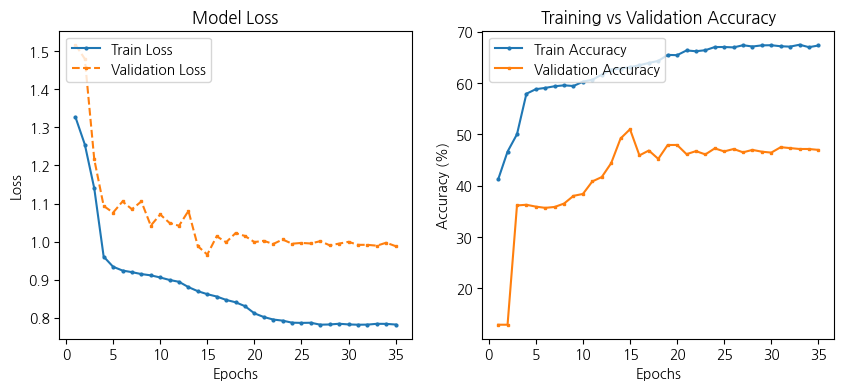


‚úÖ ÌïôÏäµ Î∞è Í≤ÄÏ¶ù Í∑∏ÎûòÌîÑ Ï†ÄÏû• ÏôÑÎ£å (/content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.png)



In [32]:
def plot_train_test_results(
    epoch_train_losses,
    epoch_train_scores,
    epoch_test_losses,
    epoch_test_scores,
    save_path="./"
    ):
    """
    ÌïôÏäµ Î∞è Í≤ÄÏ¶ù Í≥ºÏ†ïÏùò Loss Î∞è AccuracyÎ•º ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò (Train + Test).
    """
    os.makedirs(save_path, exist_ok=True)

    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)

    fig = plt.figure(figsize=(10, 4))

    # Loss Í∑∏ÎûòÌîÑ
    plt.subplot(121)
    plt.plot(np.arange(1, len(A) + 1), A, marker="o", markersize=2, linestyle="-", label="Train Loss")
    plt.plot(np.arange(1, len(C) + 1), C, marker="s", markersize=2, linestyle="--", label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    # plt.ylim((0, max(2, max(A), max(C))))

    # Accuracy Í∑∏ÎûòÌîÑ
    plt.subplot(122)
    plt.plot(np.arange(1, len(B) + 1), B, marker="o", markersize=2, linestyle="-", label="Train Accuracy")
    plt.plot(np.arange(1, len(D) + 1), D, marker="s", markersize=2, linestyle="-", label="Validation Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="upper left")
    # plt.ylim((0, 100))

    # Í∑∏ÎûòÌîÑ Ï†ÄÏû•
    plot_save_path = os.path.join(save_path, "training_results.png")
    plt.savefig(plot_save_path, dpi=600)
    plt.show()

    print(f"\n‚úÖ ÌïôÏäµ Î∞è Í≤ÄÏ¶ù Í∑∏ÎûòÌîÑ Ï†ÄÏû• ÏôÑÎ£å ({plot_save_path})\n")

plot_train_test_results(
    epoch_train_losses,
    epoch_train_scores,
    epoch_valid_losses,
    epoch_valid_scores,
    save_path=config["train_result_path"],
)

### confusion matrix ÏãúÍ∞ÅÌôî

In [33]:
# Î™®Îç∏ Î°úÎìú Ìï®Ïàò
def load_model(model, model_save_path, device):
    """Ï†ÄÏû•Îêú Î™®Îç∏ÏùÑ Î∂àÎü¨Ïò§Îäî Ìï®Ïàò"""
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"‚úÖ Model Loaded from {model_save_path}")
    return model

# Confusion Matrix ÏãúÍ∞ÅÌôî Ìï®Ïàò
def plot_confusion_matrix(y_true, y_pred, class_names, save_dir, file_name):
    """
    Confusion MatrixÎ•º Í∑∏Î¶¨Îäî Ìï®Ïàò
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Ï†ÄÏû• Í∏∞Îä• Ï∂îÍ∞Ä
    if save_dir and file_name:
        os.makedirs(save_dir, exist_ok=True)  # ÎîîÎ†âÌÜ†Î¶¨Í∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±
        save_path = os.path.join(save_dir, f"{file_name}_cm.png")
        plt.savefig(save_path, bbox_inches='tight')  # Ïù¥ÎØ∏ÏßÄ Ï†ÄÏû•
        print(f"‚úÖ Confusion Matrix saved at: {save_path}")

    plt.show()

    print("\nüîπ Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Confusion Matrix Í≥ÑÏÇ∞
def evaluate_model(model, data_loader, class_names, save_dir=None, file_name=None):
    """
    Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÌïòÍ≥† Confusion MatrixÎ•º Ï∂úÎ†•ÌïòÎäî Ìï®Ïàò
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")

            y_pred = model(x_batch)  # (batch_size, num_classes)
            y_pred_classes = torch.argmax(y_pred, dim=1)  # Í∞ÄÏû• ÎÜíÏùÄ ÌôïÎ•†ÏùÑ Í∞ÄÏßÑ ÌÅ¥ÎûòÏä§Î•º ÏòàÏ∏°Í∞íÏúºÎ°ú ÏÑ†ÌÉù

            all_preds.extend(y_pred_classes.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix Ï∂úÎ†•
    plot_confusion_matrix(all_labels, all_preds, class_names, save_dir, file_name)

‚úÖ Model Loaded from /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth
‚úÖ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/train_cm.png


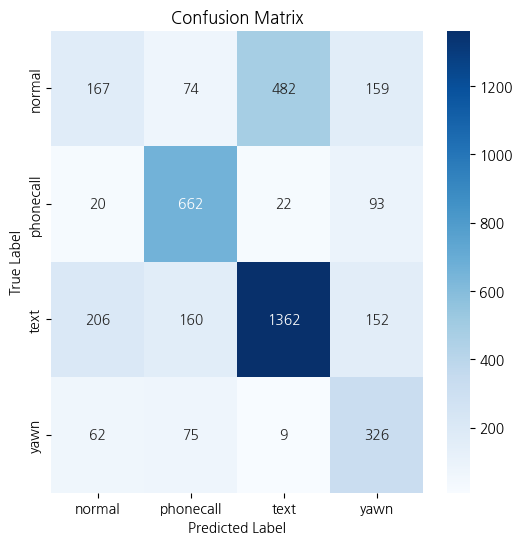


üîπ Classification Report:
              precision    recall  f1-score   support

      normal       0.37      0.19      0.25       882
   phonecall       0.68      0.83      0.75       797
        text       0.73      0.72      0.73      1880
        yawn       0.45      0.69      0.54       472

    accuracy                           0.62      4031
   macro avg       0.56      0.61      0.57      4031
weighted avg       0.61      0.62      0.60      4031



In [37]:
model = load_model(model,"/content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth", config["device"])
class_names = config['action_names']
evaluate_model(model, train_loader, class_names, save_dir=config["train_result_path"], file_name="train")

‚úÖ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/test_cm.png


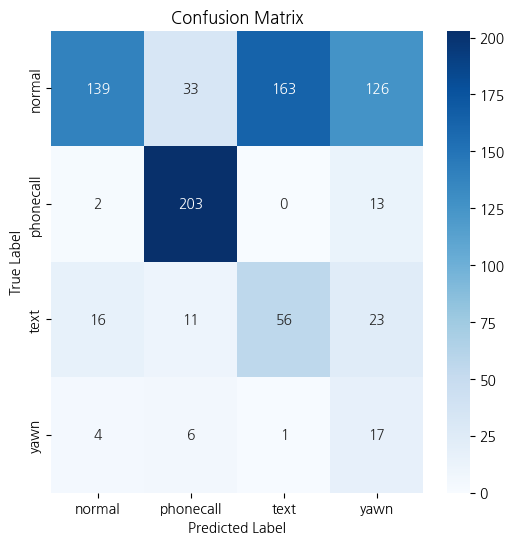


üîπ Classification Report:
              precision    recall  f1-score   support

      normal       0.86      0.30      0.45       461
   phonecall       0.80      0.93      0.86       218
        text       0.25      0.53      0.34       106
        yawn       0.09      0.61      0.16        28

    accuracy                           0.51       813
   macro avg       0.50      0.59      0.45       813
weighted avg       0.74      0.51      0.54       813



In [38]:
evaluate_model(model, validation_loader, class_names, config["train_result_path"], "test")

‚úÖ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/test_cm.png


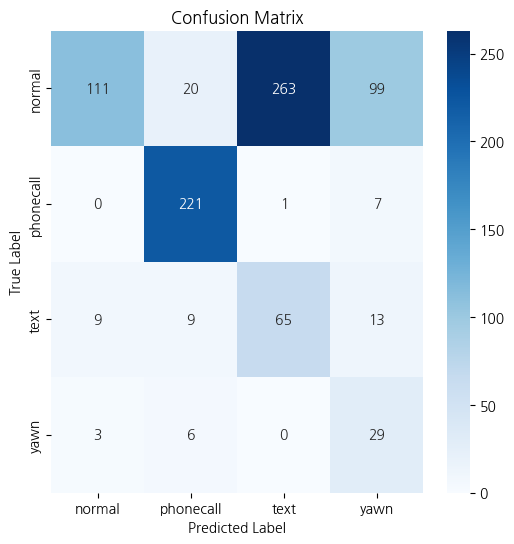


üîπ Classification Report:
              precision    recall  f1-score   support

      normal       0.90      0.23      0.36       493
   phonecall       0.86      0.97      0.91       229
        text       0.20      0.68      0.31        96
        yawn       0.20      0.76      0.31        38

    accuracy                           0.50       856
   macro avg       0.54      0.66      0.47       856
weighted avg       0.78      0.50      0.50       856



In [39]:
evaluate_model(model, test_loader, class_names, config["train_result_path"], "test")